In [65]:
import os
import numpy as np
from deepcell.utils.data_utils import get_data

DATA_DIR = r'/notebooks/data/RajLab_Organoid3'
NPZ_PATH = os.path.join(DATA_DIR, 'npz')
DATA_FILE = os.path.join(NPZ_PATH, 'organoid_lumens.npz')
test_size = .20  # % of data saved as test

train_dict, test_dict = get_data(DATA_FILE, test_size=test_size)

X_train, y_train, X_test, y_test = train_dict['X'], train_dict['y'], test_dict['X'], test_dict['y']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(318, 160, 160, 1) (318, 160, 160, 1) (80, 160, 160, 1) (80, 160, 160, 1)


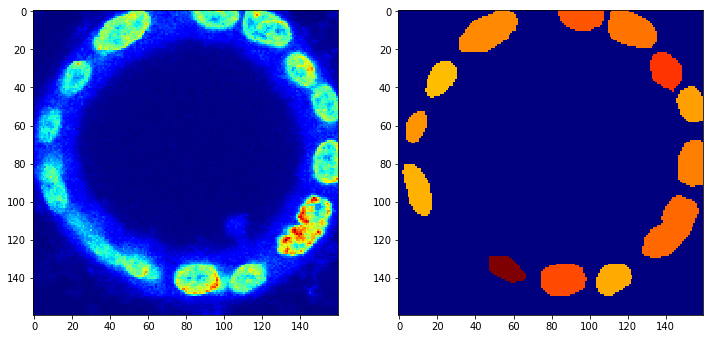

In [2]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
index = 8
frame = 28

#fg_thresh = test_images_fgbg[..., 1] > 0.95

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax[0].imshow(X_train[index, frame, ..., 0], cmap='jet')
ax[1].imshow(y_train[index, frame, ..., 0], cmap='jet')

plt.show()

In [3]:
y_train[y_train < 0] = 0
y_test[y_test < 0] = 0

train_dict = {'X' : X_train, 'y' : y_train}
test_dict = {'X' : X_test, 'y' : y_test}

In [4]:
# Set up other required filepaths

MODEL_DIR = r'/notebooks/data/models'
LOG_DIR = r'/notebooks/data/logs'

In [5]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import numpy as np
import tensorflow as tf
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import activations
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Layer, InputSpec
try:  # tf v1.9 moves conv_utils from _impl to keras.utils
    from tensorflow.python.keras.utils import conv_utils
except ImportError:
    from tensorflow.python.keras._impl.keras.utils import conv_utils

class ImageNormalization3D(Layer):
    def __init__(self,
                 norm_method='std',
                 filter_size=61,
                 data_format=None,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        self.valid_modes = {'std', 'max', None, 'whole_image'}
        if norm_method not in self.valid_modes:
            raise ValueError('Invalid `norm_method`: "{}". '
                             'Use one of {}.'.format(
                                 norm_method, self.valid_modes))
        if 'trainable' not in kwargs:
            kwargs['trainable'] = False
        super(ImageNormalization3D, self).__init__(
            activity_regularizer=regularizers.get(activity_regularizer),
            **kwargs)
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=5)  # hardcoded for 3D data

        self.filter_size = filter_size
        self.norm_method = norm_method
        self.data_format = conv_utils.normalize_data_format(data_format)

        if self.data_format == 'channels_first':
            self.channel_axis = 1
        else:
            self.channel_axis = 4  # hardcoded for 3D data

        if isinstance(self.norm_method, str):
            self.norm_method = self.norm_method.lower()

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        if len(input_shape) != 5:
            raise ValueError('Inputs should have rank 5, '
                             'received input shape: %s' % input_shape)
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined, found None: %s' % input_shape)
        input_dim = int(input_shape[channel_axis])
        self.input_spec = InputSpec(ndim=5, axes={channel_axis: input_dim})

        if self.data_format == 'channels_first':
            depth = int(input_shape[2])
        else:
            depth = int(input_shape[1])
        kernel_shape = (depth, self.filter_size, self.filter_size, input_dim, 1)
        
#         self.add_weight(
#             'kernel',
#             shape=kernel_shape,
#             initializer=self.kernel_initializer,
#             regularizer=self.kernel_regularizer,
#             constraint=self.kernel_constraint,
#             trainable=False,
#             dtype=self.dtype)

        W = np.ones(kernel_shape)
        W = W / W.size
        #self.set_weights([W])
        
        self.kernel = K.constant(W, shape=kernel_shape, name='kernel', dtype=self.dtype)

        if self.use_bias:
            self.bias = self.add_weight(
                'bias',
                shape=(depth, self.filter_size, self.filter_size),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                trainable=False,
                dtype=self.dtype)
        else:
            self.bias = None
        self.built = True

    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape).as_list()
        return tensor_shape.TensorShape(input_shape)

    def _average_filter(self, inputs):
        if self.data_format == 'channels_first':
            inputs = K.permute_dimensions(inputs, pattern=[0, 2, 3, 4, 1])
        # TODO: conv3d vs depthwise_conv2d?
        outputs = tf.nn.conv3d(inputs, self.kernel, [1, 1, 1, 1, 1],
                               padding='SAME', data_format='NDHWC')

        if self.data_format == 'channels_first':
            outputs = K.permute_dimensions(outputs, pattern=[0, 4, 1, 2, 3])
        return outputs

    def _window_std_filter(self, inputs, epsilon=K.epsilon()):
        c1 = self._average_filter(inputs)
        c2 = self._average_filter(K.square(inputs))
        output = K.sqrt(c2 - c1 * c1) + epsilon
        return output

    def call(self, inputs):
        if not self.norm_method:
            outputs = inputs

        elif self.norm_method == 'whole_image':
            axes = [3, 4] if self.channel_axis == 1 else [2, 3]
            outputs = inputs - K.mean(inputs, axis=axes, keepdims=True)
            outputs = outputs / K.std(inputs, axis=axes, keepdims=True)

        elif self.norm_method == 'std':
            outputs = inputs - self._average_filter(inputs)
            outputs = outputs / self._window_std_filter(outputs)

        elif self.norm_method == 'max':
            outputs = inputs / K.max(inputs)
            outputs = outputs - self._average_filter(outputs)

        else:
            raise NotImplementedError('"{}" is not a valid norm_method'.format(self.norm_method))

        return outputs

    def get_config(self):
        config = {
            'norm_method': self.norm_method,
            'filter_size': self.filter_size,
            'data_format': self.data_format,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(ImageNormalization3D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [9]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import numpy as np

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Conv2D, Conv3D, ConvLSTM2D, LSTM
from tensorflow.python.keras.layers import Add, Input, Concatenate, Lambda, InputLayer
from tensorflow.python.keras.layers import Flatten, Dense, Reshape
from tensorflow.python.keras.layers import MaxPool2D, MaxPool3D
from tensorflow.python.keras.layers import Cropping2D, Cropping3D
from tensorflow.python.keras.layers import Activation, Softmax
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import ZeroPadding2D, ZeroPadding3D
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import utils as keras_utils

from deepcell.layers import DilatedMaxPool2D, DilatedMaxPool3D
from deepcell.layers import ImageNormalization2D
from deepcell.layers import Location2D, Location3D
from deepcell.layers import ReflectionPadding2D, ReflectionPadding3D
from deepcell.layers import TensorProduct

def bn_feature_net_3D(receptive_field=61,
                      n_frames=5,
                      input_shape=(5, 256, 256, 1),
                      n_features=3,
                      n_channels=1,
                      reg=1e-5,
                      n_conv_filters=64,
                      n_dense_filters=200,
                      VGG_mode=False,
                      init='he_normal',
                      norm_method='std',
                      location=False,
                      dilated=False,
                      padding=False,
                      padding_mode='reflect',
                      multires=False,
                      include_top=True):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    win_z = (n_frames - 1) // 2

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    x.append(ImageNormalization3D(norm_method=norm_method, filter_size=receptive_field)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(win_z, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(win_z, win, win))([-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    if multires:
        layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d), pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))

    x.append(Conv3D(n_dense_filters, (1, rf_counter, rf_counter), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(Conv3D(n_dense_filters, (n_frames, 1, 1), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_dense_filters, kernel_initializer=init, kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_features, kernel_initializer=init, kernel_regularizer=l2(reg))(x[-1]))

    if not dilated:
        x.append(Flatten()(x[-1]))

    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])

    model.summary()
    return model


def bn_feature_net_skip_3D(receptive_field=61,
                           input_shape=(5, 256, 256, 1),
                           fgbg_model=None,
                           last_only=True,
                           n_skips=2,
                           norm_method='std',
                           padding_mode='reflect',
                           **kwargs):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    inputs = Input(shape=input_shape)
    img = ImageNormalization3D(norm_method=norm_method, filter_size=receptive_field)(inputs)

    models = []
    model_outputs = []

    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs) 
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img
        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(bn_feature_net_3D(receptive_field=receptive_field, input_shape=new_input_shape, norm_method=None, dilated=True, padding=True, padding_mode=padding_mode, **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    else:
        if fgbg_model is None:
            model = Model(inputs=inputs, outputs=model_outputs)
        else:
            model = Model(inputs=inputs, outputs=model_outputs[1:])

    model.summary()
    return model

In [10]:

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import datetime
import os

import numpy as np
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from deepcell import losses
from deepcell import image_generators
from deepcell.callbacks import RedirectModel, Evaluate
from deepcell.model_zoo import retinanet_bbox
from deepcell.utils.retinanet_anchor_utils import make_shapes_callback
from deepcell.utils.retinanet_anchor_utils import guess_shapes
from deepcell.utils.retinanet_anchor_utils import evaluate
from deepcell.utils import train_utils
from deepcell.utils import tracking_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler

def train_organoid(model,
                     dataset,
                     expt='',
                     test_size=.1,
                     n_epoch=10,
                     batch_size=1,
                     num_gpus=None,
                     frames_per_batch=5,
                     transform=None,
                     optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
                     log_dir='/data/tensorboard_logs',
                     model_dir='/data/models',
                     model_name=None,
                     focal=False,
                     gamma=0.5,
                     lr_sched=rate_scheduler(lr=0.01, decay=0.95),
                     rotation_range=0,
                     flip=True,
                     shear=0,
                     zoom_range=0,
                     seed=None,
                     **kwargs):
    is_channels_first = K.image_data_format() == 'channels_first'

    if model_name is None:
        todays_date = datetime.datetime.now().strftime('%Y-%m-%d')
        data_name = os.path.splitext(os.path.basename(dataset))[0]
        model_name = '{}_{}_{}'.format(todays_date, data_name, expt)
    model_path = os.path.join(model_dir, '{}.h5'.format(model_name))
    loss_path = os.path.join(model_dir, '{}.npz'.format(model_name))

    train_dict, test_dict = get_data(dataset, test_size=test_size, seed=seed)

    X_train, y_train, X_test, y_test = train_dict['X'], train_dict['y'], test_dict['X'], test_dict['y']

    y_train[y_train < 0] = 0
    y_test[y_test < 0] = 0

    train_dict = {'X' : X_train, 'y' : y_train}
    test_dict = {'X' : X_test, 'y' : y_test}
    
    n_classes = model.layers[-1].output_shape[1 if is_channels_first else -1]
    # the data, shuffled and split between train and test sets
    print('X_train shape:', train_dict['X'].shape)
    print('y_train shape:', train_dict['y'].shape)
    print('X_test shape:', test_dict['X'].shape)
    print('y_test shape:', test_dict['y'].shape)
    print('Output Shape:', model.layers[-1].output_shape)
    print('Number of Classes:', n_classes)

    def loss_function(y_true, y_pred):
        if isinstance(transform, str) and transform.lower() == 'disc':
            return losses.discriminative_instance_loss(y_true, y_pred)
        if focal:
            return losses.weighted_focal_loss(
                y_true, y_pred, gamma=gamma, n_classes=n_classes)
        return losses.weighted_categorical_crossentropy(
            y_true, y_pred, n_classes=n_classes)

    if num_gpus is None:
        num_gpus = train_utils.count_gpus()

    if num_gpus >= 2:
        batch_size = batch_size * num_gpus
        model = train_utils.MultiGpuModel(model, num_gpus)

    print('Training on {} GPUs'.format(num_gpus))

    model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

    if isinstance(model.output_shape, list):
        skip = len(model.output_shape) - 1
    else:
        skip = None

    if train_dict['X'].ndim == 4:
        DataGenerator = image_generators.ImageFullyConvDataGenerator
    elif train_dict['X'].ndim == 5:
        DataGenerator = image_generators.MovieDataGenerator
    else:
        raise ValueError('Expected `X` to have ndim 4 or 5. Got',
                         train_dict['X'].ndim)

    if num_gpus >= 2:
        # Each GPU must have at least one validation example
        if test_dict['y'].shape[0] < num_gpus:
            raise ValueError('Not enough validation data for {} GPUs. '
                             'Received {} validation sample.'.format(
                                 test_dict['y'].shape[0], num_gpus))

        # When using multiple GPUs and skip_connections,
        # the training data must be evenly distributed across all GPUs
        num_train = train_dict['y'].shape[0]
        nb_samples = num_train - num_train % batch_size
        if nb_samples:
            train_dict['y'] = train_dict['y'][:nb_samples]
            train_dict['X'] = train_dict['X'][:nb_samples]

    # this will do preprocessing and realtime data augmentation
    datagen = DataGenerator(
        rotation_range=rotation_range,
        shear_range=shear,
        zoom_range=zoom_range,
        horizontal_flip=flip,
        vertical_flip=flip)

    datagen_val = DataGenerator(
        rotation_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=0,
        vertical_flip=0)

    if train_dict['X'].ndim == 5:
        train_data = datagen_val.flow(
            train_dict,
            skip=skip,
            seed=seed,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=kwargs,
            frames_per_batch=frames_per_batch)

        val_data = datagen_val.flow(
            test_dict,
            skip=skip,
            seed=seed,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=kwargs,
            frames_per_batch=frames_per_batch)
    else:
        train_data = datagen.flow(
            train_dict,
            skip=skip,
            seed=seed,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=kwargs)

        val_data = datagen_val.flow(
            test_dict,
            skip=skip,
            seed=seed,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=kwargs)

    # fit the model on the batches generated by datagen.flow()
    loss_history = model.fit_generator(
        train_data,
        steps_per_epoch=150,#train_data.y.shape[0] // batch_size,
        epochs=n_epoch,
        validation_data=val_data,
        validation_steps=150,#val_data.y.shape[0] // batch_size,
        callbacks=[
            callbacks.LearningRateScheduler(lr_sched),
            callbacks.ModelCheckpoint(
                model_path, monitor='val_loss', verbose=1,
                save_best_only=True, save_weights_only=num_gpus >= 2),
            callbacks.TensorBoard(log_dir=os.path.join(log_dir, model_name))
        ])

    model.save_weights(model_path)
    np.savez(loss_path, loss_history=loss_history.history)

    return model


In [11]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'conv_fgbg_3d_model'
conv_model_name = 'conv_watershed_3d_model'

n_epoch = 10  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 21  # should be adjusted for the scale of the data

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance classes
erosion_width = 0  # erode edges

# 3D Settings
frames_per_batch = 13

In [12]:
from deepcell import model_zoo

fgbg_model = bn_feature_net_skip_3D(
    receptive_field=receptive_field,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_frames=frames_per_batch,
    n_conv_filters=24,
    n_dense_filters=32,
    n_skips=n_skips,
    input_shape=tuple([frames_per_batch] + list(X_train.shape[2:])),
    multires=False,
    last_only=False,
    norm_method=norm_method)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 13, 160, 160, 1)   0         
_________________________________________________________________
image_normalization3d_1 (Ima (None, 13, 160, 160, 1)   0         
_________________________________________________________________
reflection_padding3d (Reflec (None, 25, 180, 180, 1)   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 25, 177, 177, 24)  408       
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 177, 177, 24)  96        
_________________________________________________________________
activation (Activation)      (None, 25, 177, 177, 24)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 25, 175, 175, 24)  5208      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 13, 160, 160, 3)   0         
_________________________________________________________________
image_normalization3d_4 (Ima (None, 13, 160, 160, 3)   0         
_________________________________________________________________
reflection_padding3d_3 (Refl (None, 25, 180, 180, 3)   0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 25, 177, 177, 24)  1176      
_________________________________________________________________
batch_normalization_21 (Batc (None, 25, 177, 177, 24)  96        
_________________________________________________________________
activation_21 (Activation)   (None, 25, 177, 177, 24)  0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 25, 175, 175, 24)  5208      
__________

In [13]:
#from deepcell.training import train_model_conv

fgbg_model = train_organoid(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=fgbg_model_name,
    transform='fgbg',
    optimizer=optimizer,
    batch_size=batch_size,
    frames_per_batch=frames_per_batch,
    n_epoch=4,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=120,
    flip=True,
    shear=5,
    zoom_range=(0.8, 1.2))

X_train shape: (10, 48, 160, 160, 1)
y_train shape: (10, 48, 160, 160, 1)
X_test shape: (2, 48, 160, 160, 1)
y_test shape: (2, 48, 160, 160, 1)
Output Shape: (None, 13, 160, 160, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/4
149/150 [============================>.] - ETA: 0s - loss: 0.9994 - model_loss: 0.2491 - model_1_loss: 0.2530 - model_2_loss: 0.2457 - model_3_loss: 0.2310 - model_acc: 0.8822 - model_1_acc: 0.8840 - model_2_acc: 0.8876 - model_3_acc: 0.8930
Epoch 00001: val_loss improved from inf to 0.96976, saving model to /notebooks/data/models/conv_fgbg_3d_model.h5
150/150 [==============================] - 166s 1s/step - loss: 1.0028 - model_loss: 0.2500 - model_1_loss: 0.2538 - model_2_loss: 0.2466 - model_3_loss: 0.2318 - model_acc: 0.8818 - model_1_acc: 0.8838 - model_2_acc: 0.8875 - model_3_acc: 0.8926 - val_loss: 0.9698 - val_model_loss: 0.2391 - val_model_1_loss: 0.2456 - val_model_2_loss: 0.2507 - val_model_3_loss: 0.2122 - val_model_acc: 0.8816 - val_model_1_acc

In [16]:
fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
fgbg_model.save_weights(fgbg_weights_file)

In [14]:
watershed_model = bn_feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=48,
    multires=False,
    last_only=False,
    input_shape=tuple([frames_per_batch] + list(X_train.shape[2:])),
    norm_method='whole_image')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 13, 160, 160, 3)   0         
_________________________________________________________________
image_normalization3d_6 (Ima (None, 13, 160, 160, 3)   0         
_________________________________________________________________
reflection_padding3d_4 (Refl (None, 25, 180, 180, 3)   0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 25, 177, 177, 32)  1568      
_________________________________________________________________
batch_normalization_28 (Batc (None, 25, 177, 177, 32)  128       
_________________________________________________________________
activation_28 (Activation)   (None, 25, 177, 177, 32)  0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 25, 175, 175, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 13, 160, 160, 5)   0         
_________________________________________________________________
image_normalization3d_9 (Ima (None, 13, 160, 160, 5)   0         
_________________________________________________________________
reflection_padding3d_7 (Refl (None, 25, 180, 180, 5)   0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 25, 177, 177, 32)  2592      
_________________________________________________________________
batch_normalization_49 (Batc (None, 25, 177, 177, 32)  128       
_________________________________________________________________
activation_49 (Activation)   (None, 25, 177, 177, 32)  0         
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 25, 175, 175, 32)  9248      
__________

In [15]:
from deepcell.training import train_model_conv

watershed_model = train_organoid(
    model=watershed_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=conv_model_name,
    transform=transform,
    distance_bins=distance_bins,
    erosion_width=erosion_width,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=10,
    frames_per_batch=frames_per_batch,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (10, 48, 160, 160, 1)
y_train shape: (10, 48, 160, 160, 1)
X_test shape: (2, 48, 160, 160, 1)
y_test shape: (2, 48, 160, 160, 1)
Output Shape: (None, 13, 160, 160, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/10
149/150 [============================>.] - ETA: 1s - loss: 4.1651 - model_5_loss: 0.9659 - model_6_loss: 0.9781 - model_7_loss: 1.0132 - model_8_loss: 1.0360 - model_5_acc: 0.8346 - model_6_acc: 0.8233 - model_7_acc: 0.8036 - model_8_acc: 0.8012
Epoch 00001: val_loss improved from inf to 8.42512, saving model to /notebooks/data/models/conv_watershed_3d_model.h5
150/150 [==============================] - 281s 2s/step - loss: 4.1620 - model_5_loss: 0.9650 - model_6_loss: 0.9775 - model_7_loss: 1.0124 - model_8_loss: 1.0350 - model_5_acc: 0.8350 - model_6_acc: 0.8238 - model_7_acc: 0.8041 - model_8_acc: 0.8017 - val_loss: 8.4251 - val_model_5_loss: 2.6351 - val_model_6_loss: 1.2055 - val_model_7_loss: 1.9242 - val_model_8_loss: 2.4763 - val_model_5_acc: 0.8210

In [17]:
watershed_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_model_name))
watershed_model.save_weights(watershed_weights_file)

In [18]:
run_model = bn_feature_net_skip_3D(
    receptive_field=receptive_field,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_frames=frames_per_batch,
    n_skips=n_skips,
    n_conv_filters=24,
    n_dense_filters=32,
    input_shape=tuple(X_test.shape[1:]),
    multires=False,
    last_only=False,
    norm_method=norm_method)
run_model.load_weights(fgbg_weights_file)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 48, 160, 160, 1)   0         
_________________________________________________________________
image_normalization3d_11 (Im (None, 48, 160, 160, 1)   0         
_________________________________________________________________
reflection_padding3d_8 (Refl (None, 60, 180, 180, 1)   0         
_________________________________________________________________
conv3d_48 (Conv3D)           (None, 60, 177, 177, 24)  408       
_________________________________________________________________
batch_normalization_56 (Batc (None, 60, 177, 177, 24)  96        
_________________________________________________________________
activation_56 (Activation)   (None, 60, 177, 177, 24)  0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 60, 175, 175, 24)  5208      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 48, 160, 160, 3)   0         
_________________________________________________________________
image_normalization3d_14 (Im (None, 48, 160, 160, 3)   0         
_________________________________________________________________
reflection_padding3d_11 (Ref (None, 60, 180, 180, 3)   0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 60, 177, 177, 24)  1176      
_________________________________________________________________
batch_normalization_77 (Batc (None, 60, 177, 177, 24)  96        
_________________________________________________________________
activation_77 (Activation)   (None, 60, 177, 177, 24)  0         
_________________________________________________________________
conv3d_67 (Conv3D)           (None, 60, 175, 175, 24)  5208      
__________

In [19]:
run_watershed_model = bn_feature_net_skip_3D(
    fgbg_model=run_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=48,
    multires=False,
    last_only=False,
    input_shape=tuple(X_test.shape[1:]),
    norm_method=norm_method)
run_watershed_model.load_weights(watershed_weights_file)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 48, 160, 160, 3)   0         
_________________________________________________________________
image_normalization3d_16 (Im (None, 48, 160, 160, 3)   0         
_________________________________________________________________
reflection_padding3d_12 (Ref (None, 60, 180, 180, 3)   0         
_________________________________________________________________
conv3d_72 (Conv3D)           (None, 60, 177, 177, 32)  1568      
_________________________________________________________________
batch_normalization_84 (Batc (None, 60, 177, 177, 32)  128       
_________________________________________________________________
activation_84 (Activation)   (None, 60, 177, 177, 32)  0         
_________________________________________________________________
conv3d_73 (Conv3D)           (None, 60, 175, 175, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 48, 160, 160, 5)   0         
_________________________________________________________________
image_normalization3d_19 (Im (None, 48, 160, 160, 5)   0         
_________________________________________________________________
reflection_padding3d_15 (Ref (None, 60, 180, 180, 5)   0         
_________________________________________________________________
conv3d_90 (Conv3D)           (None, 60, 177, 177, 32)  2592      
_________________________________________________________________
batch_normalization_105 (Bat (None, 60, 177, 177, 32)  128       
_________________________________________________________________
activation_105 (Activation)  (None, 60, 177, 177, 32)  0         
_________________________________________________________________
conv3d_91 (Conv3D)           (None, 60, 175, 175, 32)  9248      
__________

In [43]:
test_images = run_watershed_model.predict(X_test)[-1]
test_images_fgbg = run_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (9, 48, 160, 160, 4)
segmentation mask shape: (9, 48, 160, 160, 2)


In [44]:
argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (9, 48, 160, 160, 1)


In [45]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

argmax_images_post_fgbg = argmax_images * fg_thresh

In [46]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(
        test_images[i, ..., -1],
        min_distance=10,
        threshold_abs=0.05,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)

Image: 3
Frame: 5


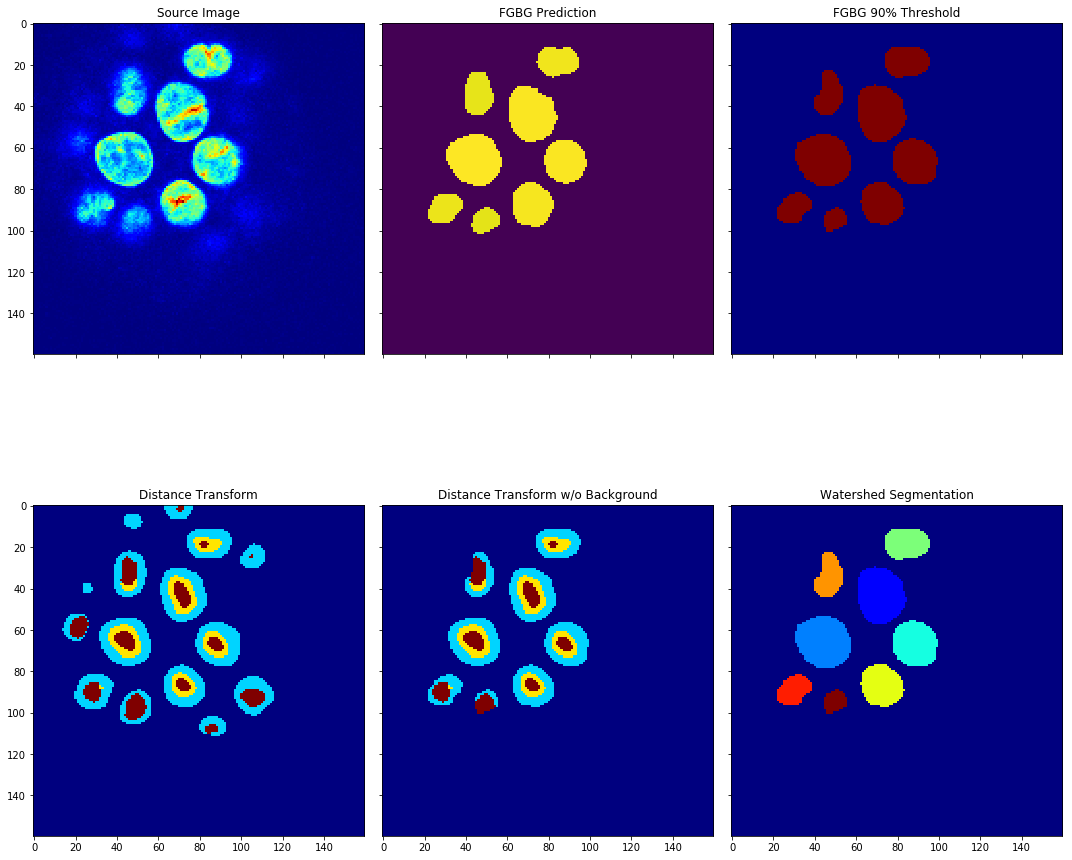

In [52]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = np.random.randint(low=0, high=watershed_images.shape[0])
frame = np.random.randint(low=0, high=watershed_images.shape[1])
index = 3
frame = 5
print('Image:', index)
print('Frame:', frame)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0], cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(y_test[index, frame, ..., 0])
ax[1].set_title('FGBG Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG {}% Threshold'.format(int(threshold * 100)))

ax[3].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[3].set_title('Distance Transform')

ax[4].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform w/o Background')

ax[5].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

In [442]:
np.savez(r'/notebooks/data/organoid_outputs_nuclei_2.npz', watershed=watershed_images, gt=y_test)

In [55]:
# Can also export as a video
# But this does not render well on GitHub
from IPython.display import HTML
#from deepcell.utils.plot_utils import get_js_video

def get_js_video(images, batch=0, channel=0, cmap='jet', vmin=0, vmax=30):
    """Create a JavaScript video as HTML for visualizing 3D data as a movie"""
    fig = plt.figure()

    ims = []
    plot_kwargs = {
        'animated': True,
        'cmap': cmap,
        'vmin': vmin,
        'vmax': vmax
    }

    # TODO: do these not work for other cmaps?
    if cmap == 'cubehelix':
        plot_kwargs['vmin'] = vmin
        plot_kwargs['vmax'] = vmax

    for i in range(images.shape[1]):
        im = plt.imshow(images[batch, i, :, :, channel], **plot_kwargs)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)
    plt.close()
    return ani.to_jshtml()

HTML(get_js_video(watershed_images[..., [-1]], batch=index, vmax=watershed_images.max()))

In [63]:
# Can also export as a video
# But this does not render well on GitHub
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

HTML(get_js_video(y_train[..., [-1]], batch=index))

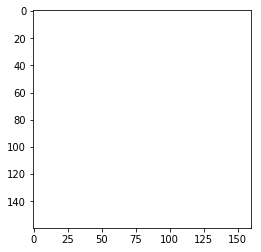

In [64]:
fig = plt.figure()

image = y_train[3, ..., 0]

ims = []
plot_kwargs = {
    'animated': True,
    'cmap': 'jet',
    'vmin': 0,
    'vmax': image.max()
}

for i in range(X_test.shape[1]):
    im = plt.imshow(image[i, ...], **plot_kwargs)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)
plt.close

ani.save(r'/notebooks/data/nuclei_segmentation_final_gt2.html', writer='html')